# Peter at ang Lobo: Mas Realistik na Kapaligiran

Sa ating sitwasyon, si Peter ay nakakapaglakad-lakad halos nang hindi napapagod o nagugutom. Sa mas realistik na mundo, kailangan niyang umupo at magpahinga paminsan-minsan, at magpakain din sa sarili. Gawin natin ang ating mundo na mas makatotohanan sa pamamagitan ng pagpapatupad ng mga sumusunod na patakaran:

1. Sa paglipat mula sa isang lugar patungo sa iba, nawawala ang **enerhiya** ni Peter at nadaragdagan ang kanyang **pagkapagod**.
2. Makakakuha si Peter ng mas maraming enerhiya sa pamamagitan ng pagkain ng mansanas.
3. Mawawala ang pagkapagod ni Peter sa pamamagitan ng pagpapahinga sa ilalim ng puno o sa damuhan (halimbawa, pagpunta sa lokasyon ng board na may puno o damo - berdeng lugar).
4. Kailangan hanapin at patayin ni Peter ang lobo.
5. Upang mapatay ang lobo, kailangang may tiyak na antas ng enerhiya at pagkapagod si Peter, kung hindi ay matatalo siya sa laban.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

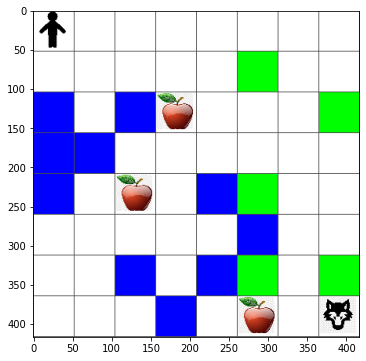

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Pagpapaliwanag ng estado

Sa ating mga bagong patakaran sa laro, kailangan nating subaybayan ang enerhiya at pagkapagod sa bawat estado ng board. Kaya't gagawa tayo ng isang object na tinatawag na `state` na magdadala ng lahat ng kinakailangang impormasyon tungkol sa kasalukuyang estado ng problema, kabilang ang estado ng board, kasalukuyang antas ng enerhiya at pagkapagod, at kung maaari nating talunin ang lobo habang nasa terminal na estado:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Paggantimpala na Function

Ang reward function ay isang mahalagang bahagi ng reinforcement learning. Ito ang tumutukoy kung paano sinusukat ang tagumpay ng isang agent sa pag-abot sa layunin nito.

### Layunin ng Reward Function

Ang pangunahing layunin ng reward function ay gabayan ang agent sa tamang direksyon. Sa pamamagitan ng pagbibigay ng positibo o negatibong gantimpala, natututo ang agent kung aling mga aksyon ang dapat nitong gawin upang makamit ang layunin.

### Mga Halimbawa ng Reward Function

Narito ang ilang mga halimbawa kung paano maaaring idisenyo ang reward function:

1. **Simpleng Gantimpala**  
   Ang agent ay binibigyan ng +1 na gantimpala para sa bawat tamang aksyon, at -1 para sa bawat maling aksyon.

2. **Distansya sa Layunin**  
   Ang gantimpala ay batay sa kung gaano kalapit ang agent sa layunin. Halimbawa, mas mataas ang gantimpala kapag mas malapit ang agent sa target.

3. **Pag-optimize ng Oras**  
   Ang gantimpala ay maaaring nakabatay sa bilis ng pagkumpleto ng layunin. Halimbawa, mas mataas ang gantimpala kung mas mabilis natapos ang gawain.

### Mga Bagay na Dapat Tandaan

- [!NOTE] Ang reward function ay dapat na maingat na idisenyo upang maiwasan ang hindi inaasahang pag-uugali ng agent.
- [!WARNING] Ang sobrang komplikadong reward function ay maaaring magdulot ng kahirapan sa pag-aaral ng agent.
- [!TIP] Subukang magsimula sa isang simpleng reward function at unti-unting i-refine ito habang natututo ang agent.
- [!IMPORTANT] Siguraduhing ang reward function ay naaayon sa layunin ng proyekto.
- [!CAUTION] Iwasan ang pagbibigay ng gantimpala para sa mga aksyon na maaaring magdulot ng pinsala o hindi kanais-nais na resulta.

### Konklusyon

Ang tamang disenyo ng reward function ay mahalaga para sa tagumpay ng reinforcement learning. Sa pamamagitan ng maingat na pagpaplano at pagsubok, maaari kang lumikha ng isang reward function na epektibong gumagabay sa agent sa tamang direksyon.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Algorithm ng Q-Learning

Ang aktwal na algorithm ng pag-aaral ay halos hindi nagbabago, ginagamit lang natin ang `state` sa halip na posisyon ng board lamang.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

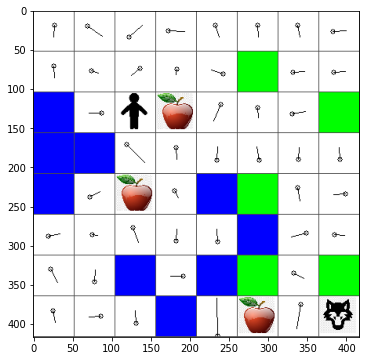

In [11]:
m.plot(Q)

## Mga Resulta

Tingnan natin kung naging matagumpay tayo sa pagsasanay kay Peter na labanan ang lobo!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Ngayon, mas kaunti na ang mga kaso ng pagkalunod, ngunit hindi pa rin laging nagagawa ni Peter na patayin ang lobo. Subukang mag-eksperimento at tingnan kung maaari mong mapabuti ang resulta sa pamamagitan ng paglalaro sa mga hyperparameter.


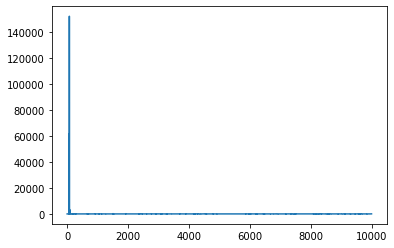

In [13]:
plt.plot(lpath)


---

**Paunawa**:  
Ang dokumentong ito ay isinalin gamit ang AI translation service na [Co-op Translator](https://github.com/Azure/co-op-translator). Bagama't sinisikap naming maging tumpak, tandaan na ang mga awtomatikong pagsasalin ay maaaring maglaman ng mga pagkakamali o hindi pagkakatugma. Ang orihinal na dokumento sa kanyang katutubong wika ang dapat ituring na opisyal na sanggunian. Para sa mahalagang impormasyon, inirerekomenda ang propesyonal na pagsasalin ng tao. Hindi kami mananagot sa anumang hindi pagkakaunawaan o maling interpretasyon na dulot ng paggamit ng pagsasaling ito.
